In [5]:
from torch_geometric.utils.convert import from_networkx
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt
import local2global as l2g
import local2global.example as ex
import local2global_embedding


import torch_geometric as tg
import pandas as pd
from torch_geometric.data import Data
import torch_scatter as ts

import glob
import os

from scipy.linalg import sqrtm
from scipy.sparse import diags


import scipy.sparse as ss
import scipy.sparse.linalg as sl

from local2global import Patch
import Local2Global_embedding.local2global_embedding.embedding.svd as svd
import Local2Global_embedding.local2global_embedding.embedding.gae as gae

import matplotlib.cm as cm


# Autonomous systems graph

The graph of routers comprising the Internet can be organized into sub-graphs called Autonomous Systems (AS). Each AS exchanges traffic flows with some neighbors (peers). We can construct a communication network of who-talks-to- whom from the BGP (Border Gateway Protocol) logs.
We use the the Autonomous Systems (AS) dataset from [26]. The dataset contains 735 daily instances which span an in- terval of 785 days from November 8 1997 to January 2 2000.
In contrast to citation networks, where nodes and edges only get added (not deleted) over time, the AS dataset also exhibits both the addition and deletion of the nodes and edges over time.
Figure 2(c) shows the DPL plot for the Autonomous Systems dataset. We observe a clear trend: Even in the presence of noise, changing external conditions, and disruptions to the Internet we observe a strong super-linear growth in the number of edges over more than 700 AS graphs. We show the increase in the average node degree over time in Figure 1(c). The densification exponent is a = 1.18, lower than the one for the citation networks, but still clearly greater than 1.


In [6]:
file_list = glob.glob(os.path.join(os.getcwd(), "Data/AS", "*.txt"))

corpus = [np.loadtxt(file).astype('int64') for file in sorted(file_list)]
data=corpus

In [7]:
graphs=[nx.from_edgelist(list(g)) for g in data]
tgraphs=[from_networkx(G) for G in graphs]

In [8]:
avg_degree=[]
number_of_nodes=[]
number_of_edges=[]
is_connected=[]
diameter=[]
for G in graphs:
    number_of_nodes.append(G.number_of_nodes())
    number_of_edges.append(G.number_of_edges())
    is_connected.append(nx.is_connected(G))
    avg_degree.append(sum(dict(G.degree()).values())/G.number_of_nodes())
    #diameter.append(nx.diameter(G))

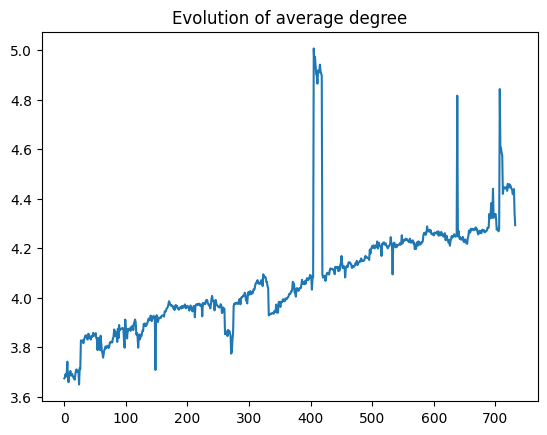

In [9]:
plt.plot(avg_degree)
plt.title('Evolution of average degree')
plt.show()

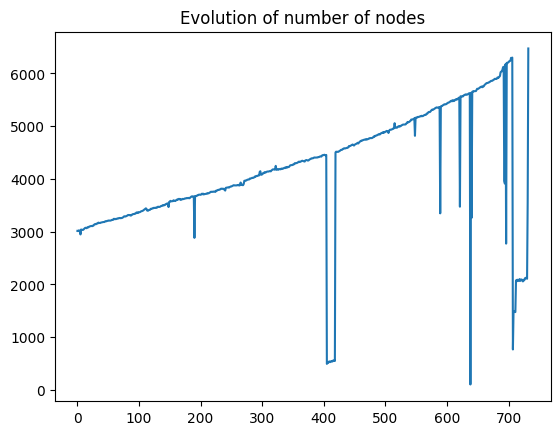

In [10]:
plt.plot(number_of_nodes)
plt.title('Evolution of number of nodes')
plt.show()

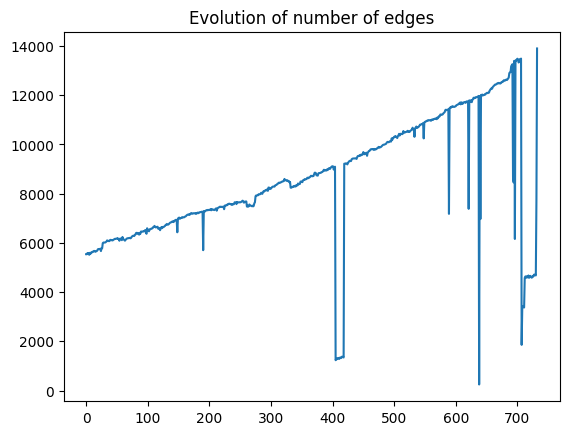

In [11]:
plt.plot(number_of_edges)
plt.title('Evolution of number of edges')
plt.show()

In [12]:
print(f'The graph with the smallest number of edges is graph ', number_of_edges.index(min(number_of_edges)))
print(f'The graph with the smallest number of nodes is graph' ,  number_of_nodes.index(min(number_of_nodes)))
smallest_graph=graphs[number_of_nodes.index(min(number_of_nodes))]
print('The smallest graph has {} nodes'.format(number_of_nodes[number_of_nodes.index(min(number_of_nodes))]))
print('The smallest graph has {} edges'.format(number_of_edges[number_of_edges.index(min(number_of_edges))]))

print(f'The graph with the bigger number of edges is graph ', number_of_edges.index(max(number_of_edges)))
print(f'The graph with the bigger number of nodes is graph' ,  number_of_nodes.index(max(number_of_nodes)))
biggest_graph=graphs[number_of_nodes.index(max(number_of_nodes))]
print('The smallest graph has {} nodes'.format(number_of_nodes[number_of_nodes.index(max(number_of_nodes))]))
print('The smallest graph has {} edges'.format(number_of_edges[number_of_edges.index(max(number_of_edges))]))

The graph with the smallest number of edges is graph  638
The graph with the smallest number of nodes is graph 638
The smallest graph has 103 nodes
The smallest graph has 248 edges
The graph with the bigger number of edges is graph  732
The graph with the bigger number of nodes is graph 732
The smallest graph has 6474 nodes
The smallest graph has 13895 edges


In [ ]:
plt.figure()  
plt.title('Smallest graph')
nx.draw(smallest_graph, node_size=20)
plt.show()

In [ ]:
plt.figure()  
plt.title('Biggest graph')
nx.draw(biggest_graph, node_size=2)
plt.show()

In [13]:
list_set_nodes=[set(graphs[i].nodes()) for i in range(len(graphs))]

nodes_in_intersection=set.intersection(*[set(gr) for gr in list_set_nodes])

print(f'The number of nodes in the intersection of all graphs is:', len(nodes_in_intersection))


The number of nodes in the intersection of all graphs is: 45


In [14]:
nodes_in_union=set()
for s in list_set_nodes:
    nodes_in_union = nodes_in_union.union(s)
    
# note not all number from 0 to max of nodes appear in at least 1 graph.


print(f'The number of nodes in the union of all graphs is:', len(nodes_in_union))

The number of nodes in the union of all graphs is: 7716


In [15]:
most_connected_node_in_graph=[]
for g in graphs:
    most_connected_node_in_graph.append(max(dict(g.degree()), key=dict(g.degree()).get))


In [16]:
missing_nodes=set(i for i in range(max(nodes_in_union)))
for i in range(max(nodes_in_union)):
                  if i in nodes_in_union:
                      missing_nodes.remove(i)



In [17]:
#matrix of size (max of nodes,number of graphs) in entry i,j tells us if the nodes i appears in graph j
#maybe could be saved as a sparse matrix since many entries are 0.
life_nodes_matrix=np.zeros((max(nodes_in_union), len(list_set_nodes)))
for i in range(max(nodes_in_union)):
    for j in range(len(list_set_nodes)):
        life_nodes_matrix[i,j]+=int(i in list_set_nodes[j])

In [18]:
consecutive_intersections=[set.intersection(list_set_nodes[i], list_set_nodes[i+1]) for i in range(len(list_set_nodes)-1)]
numb_con_intersections=[len(c) for c in consecutive_intersections]
dying_nodes=[list_set_nodes[i].difference(consecutive_intersections[i]) for i in range(len(consecutive_intersections)) ]
appearing_nodes=[list_set_nodes[i+1].difference(consecutive_intersections[i]) for i in range(len(consecutive_intersections)-1)]
numb_appearing_nodes=[len(an) for an in appearing_nodes]
numb_dying_nodes=[len(dn) for dn in dying_nodes]

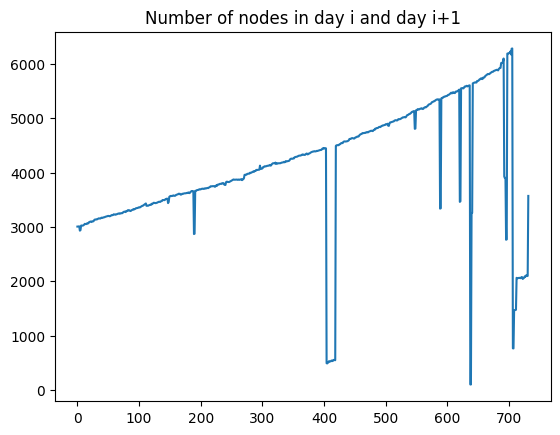

In [19]:
plt.plot(numb_con_intersections)
plt.title('Number of nodes in day i and day i+1')
plt.show()

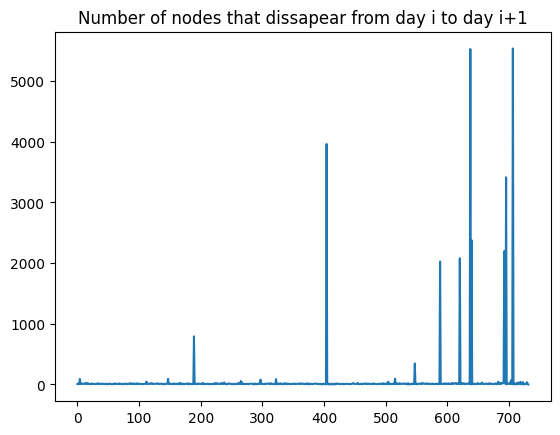

In [20]:
plt.plot(numb_dying_nodes)
plt.title('Number of nodes that dissapear from day i to day i+1')
plt.show()

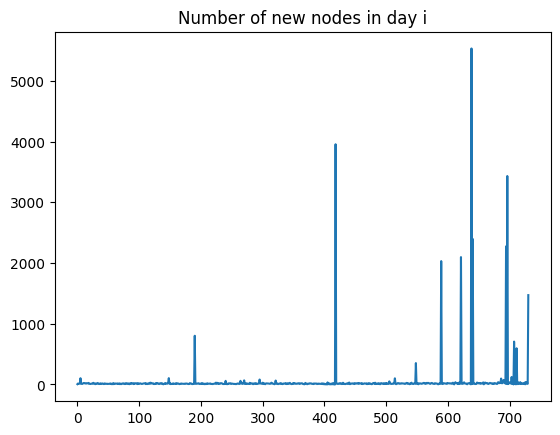

In [21]:
plt.plot(numb_appearing_nodes)
plt.title('Number of new nodes in day i')
plt.show()

In [22]:
how_many=100
sub_tgraphs=tgraphs[:how_many]
sub_graphs=graphs[:how_many]

In [23]:
sub_list_set_nodes=[set(graphs[i].nodes()) for i in range(len(sub_graphs))]
nodes_in_sub_graphs=set()
for s in sub_list_set_nodes:
    nodes_in_sub_graphs = nodes_in_sub_graphs.union(s)

print('The number of nodes in the union of the first {} graphs is : {}'.format(len(sub_graphs), len(nodes_in_sub_graphs)))

The number of nodes in the union of the first 100 graphs is : 3569


# SVD

In [22]:
def svd_patches(A: ss.spmatrix, dim, verbose=0):
    """
    SVD embedding from Chapter 5

    """
    
    index,_= A.sum(axis=1).nonzero()
    diag=A.sum(axis=1)
    diag=np.asfarray(np.squeeze(np.asarray(diag)))
    for i in range(len(diag)):
        if diag[i]!=0:
            diag[i]=np.reciprocal(diag[i])
    diag=np.sqrt(diag)
    D=ss.dia_array((diag,0), shape=(np.shape(A)[0],np.shape(A)[1]))
    A= D@ A@D
    U,s,V=svd._svds_laplacian(A, k=100, verbose=0)

    return Patch(index, D@U)

In [23]:
my_sub_sparse_adj=[]
for i in range(len(sub_graphs)):
    
    row=corpus[i][:,0]
    col=corpus[i][:,1]
    np.ones(len(row))
    SS=ss.coo_matrix((np.ones(len(row)), (row,col)), shape=(max(row)+1,max(row)+1))
    my_sub_sparse_adj.append(SS)


sub_sparse_adj=[nx.adjacency_matrix(a) for a in sub_graphs]

/tmp/ipykernel_6168/1078353170.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sub_sparse_adj=[nx.adjacency_matrix(a) for a in sub_graphs]


In [24]:
new_patches=[svd_patches(a, dim=100) for a in my_sub_sparse_adj]
#big_patches=[svd_patches(a, dim=2) for a in my_sub_sparse_adj]

/home/mathscdt/pytorch_env/Local2Global_private-master/doc/git/Local2Global_embedding/local2global_embedding/embedding/svd.py:129: RuntimeWarning: divide by zero encountered in power
  D1 = ss.diags(d1 ** (-0.5))
/home/mathscdt/pytorch_env/Local2Global_private-master/doc/git/Local2Global_embedding/local2global_embedding/embedding/svd.py:132: RuntimeWarning: divide by zero encountered in power
  D2 = ss.diags(d2 ** -0.5)
/home/mathscdt/pytorch_env/Local2Global_private-master/doc/git/Local2Global_embedding/local2global_embedding/embedding/svd.py:164: UserWarning: Exited at iteration 100 with accuracies 
[4.44247217e-10 8.40122616e-10 9.38140308e-10 7.01364735e-10
 4.68044010e-10 5.73640234e-10 1.00443522e-09 8.48123338e-10
 5.80400757e-10 6.45072524e-10 9.16534930e-10 8.69622897e-10
 7.63880616e-10 1.05940193e-09 9.05131421e-10 8.20538883e-10
 7.05070828e-10 8.76410871e-10 6.20936772e-10 9.54641806e-10
 9.30235549e-10 1.14549590e-09 8.24573902e-10 7.55180456e-10
 7.92560364e-10 1.0552403

In [25]:
for p in new_patches:
    p.coordinates=p.coordinates[list(p.index.keys())]

In [26]:
#for i in range(10):
    #print(np.shape(big_patches[i].coordinates), np.shape(new_patches[i].coordinates))

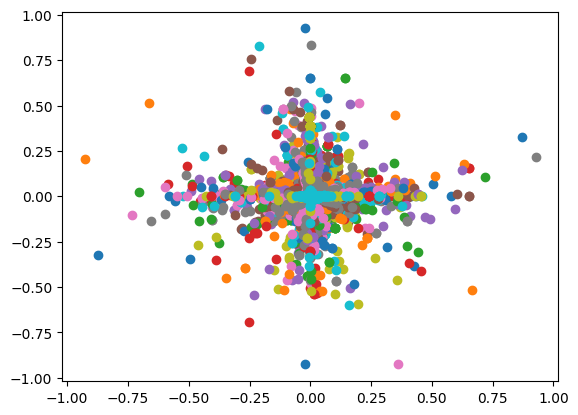

In [27]:
for p in new_patches:
    plt.scatter(p.coordinates[:,0], p.coordinates[:,1])

In [ ]:
prob = l2g.utils.WeightedAlignmentProblem(new_patches) #embedding of the full graph using embeddings of each patch
emb=prob.get_aligned_embedding(scale=False, realign=False)
#big_prob=l2g.utils.WeightedAlignmentProblem(big_patches)

Compute relative transformations:   0%|          | 0/9900 [00:00<?, ?it/s]

In [1]:
for p in prob.patches:
    plt.scatter(p.coordinates[:,0], p.coordinates[:,1])

NameError: name 'prob' is not defined

In [ ]:
plt.title('Embedding of full graph using SVD')
plt.scatter(emb[:,0], emb[:, 1])

# VGAE

In [24]:
patches=[from_networkx(G) for G in graphs[:how_many]]


In [25]:
for i, p in enumerate(patches):
    p.nodes=torch.Tensor(list(graphs[i].nodes)).int()

In [26]:
import torch.nn.functional as F
def speye(n, dtype=torch.float):
    """identity matrix of dimension n as sparse_coo_tensor."""
    return torch.sparse_coo_tensor(torch.tile(torch.arange(n, dtype=torch.long), (2, 1)),
                                   torch.ones(n, dtype=dtype),
                                   (n, n))
class VGAEconv(torch.nn.Module):
    def __init__(self, dim, num_node_features, hidden_dim=32, cached=True, bias=True, add_self_loops=True, normalize=True):
        super().__init__()
        self.conv1 = tg.nn.GCNConv(num_node_features, hidden_dim, cached=cached, bias=bias, add_self_loops=add_self_loops,
                                   normalize=normalize)
        self.mean_conv2 = tg.nn.GCNConv(hidden_dim, dim, cached=cached, bias=bias, add_self_loops=add_self_loops,
                                        normalize=normalize)
        self.var_conv2 = tg.nn.GCNConv(hidden_dim, dim, cached=cached, bias=bias, add_self_loops=add_self_loops,
                                       normalize=normalize)

    def forward(self, data: tg.data.Data):
        x = data.x
        edge_index = data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)

        mu = self.mean_conv2(x, edge_index)
        sigma = self.var_conv2(x, edge_index)
        return mu, sigma

def train(data, model, loss_fun, num_epochs=100, verbose=True, lr=0.01, logger=lambda loss: None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    # schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
    for e in range(num_epochs):
        optimizer.zero_grad()
        loss = loss_fun(model, data)
        loss.backward()
        optimizer.step()
        logger(float(loss))
        if verbose:
            print(f'epoch {e}: loss={loss.item()}')
        # schedule.step()
    return model

def VGAE_patch_embeddings(patch_data, dim=2, hidden_dim=32, num_epochs=100, decoder=None, device='cpu', lr=0.01):
    patch_list = []
    models = []
    for patch in patch_data:
        
        
        
        if patch.x is None:
            patch.x = speye(patch.num_nodes)
            print(f"training patch with {patch.edge_index.shape[1]} edges")   #added [i] to every patch
            model = tg.nn.VGAE(encoder=VGAEconv(dim, patch.x.shape[1], hidden_dim=hidden_dim), decoder=decoder).to(device)
            patch.to(device)

        def loss_fun(model, data):
            return model.recon_loss(model.encode(data), data.edge_index) + model.kl_loss() / data.num_nodes

        model = train(patch, model, loss_fun, num_epochs=num_epochs, lr=lr)
        with torch.no_grad():
            model.eval()
            coordinates = model.encode(patch).to('cpu').numpy()
            models.append(model)
            patch_list.append(l2g.Patch(patch.nodes.to('cpu').numpy(), coordinates))
    return patch_list, models

In [27]:
VGAE_patches, VGAE_model=VGAE_patch_embeddings(patches, dim=100, hidden_dim=32, num_epochs=50, decoder=None, device='cpu', lr=0.01)

training patch with 10695 edges
epoch 0: loss=8.389754295349121
epoch 1: loss=8.153983116149902
epoch 2: loss=8.057622909545898
epoch 3: loss=7.324742794036865
epoch 4: loss=6.8319010734558105
epoch 5: loss=6.057489395141602
epoch 6: loss=5.461873531341553
epoch 7: loss=5.024266242980957
epoch 8: loss=4.662662029266357
epoch 9: loss=4.382189750671387
epoch 10: loss=4.059046268463135
epoch 11: loss=3.6675171852111816
epoch 12: loss=3.19981050491333
epoch 13: loss=2.8502848148345947
epoch 14: loss=2.5249319076538086
epoch 15: loss=2.308422327041626
epoch 16: loss=2.087313413619995
epoch 17: loss=1.924512505531311
epoch 18: loss=1.79646897315979
epoch 19: loss=1.703963041305542
epoch 20: loss=1.6372101306915283
epoch 21: loss=1.5619863271713257
epoch 22: loss=1.463850736618042
epoch 23: loss=1.3727973699569702
epoch 24: loss=1.3251975774765015
epoch 25: loss=1.3054461479187012
epoch 26: loss=1.2822073698043823
epoch 27: loss=1.2735857963562012
epoch 28: loss=1.2445800304412842
epoch 29: l

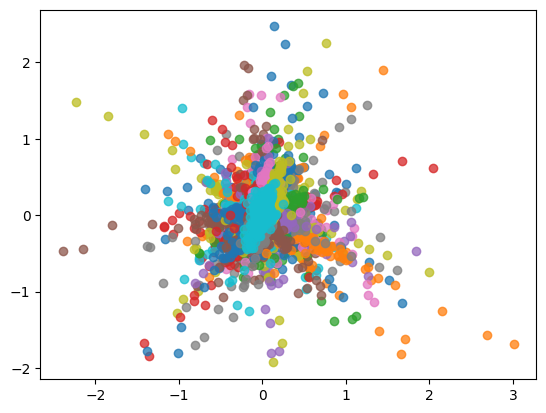

In [28]:
for p in VGAE_patches:
    plt.scatter(p.coordinates[:, 0], p.coordinates[:, 1], alpha =.75)

In [ ]:
VGAE_prob = l2g.utils.WeightedAlignmentProblem(VGAE_patches)  #embedding of the full graph using embeddings of each patch
VGAE_emb=VGAE_prob.get_aligned_embedding()

Compute relative transformations:   0%|          | 0/9900 [00:00<?, ?it/s]

In [ ]:
for p in VGAE_prob.patches:
    plt.scatter(p.coordinates[:,0], p.coordinates[:,1])

In [ ]:
plt.title('Embedding of full graph using VGAE')
plt.scatter(VGAE_emb[:,0], VGAE_emb[:, 1])


# Anomaly Detection implementation

In [ ]:
def index_node_in_patch(node, patch):
    if node in set(patch.index.keys()):
        return patch.index[node]
    else:
        return print('Node not in patch')

def index_node_in_tot(node):
    return emb[n]

def is_in_patch(node, patch):
    return node in patch.index.keys()




In [ ]:
SVD_aligned_patches=prob.patches
VGAE_aligned_patches=VGAE_prob.patches


In [ ]:
#def error(aligned_patches, emb):
  #  'patches: list of aligned patches'
    #'emb: aligned embedding (centroid of emb of patches)'
    
    #return [np.linalg.norm(p.coordinates-emb[list(p.index.keys())], axis=1) for p in aligned_patches]


def anomaly(aligned_patches, emb):
    error=[np.linalg.norm(p.coordinates-emb[list(p.index.keys())], axis=1) for p in aligned_patches]
    mu=[]
    std=[]
   
    for i in range(len(aligned_patches)):
        nodes_in_patch=list(aligned_patches[i].index.keys())
        m=[]
        for l, n in  enumerate(nodes_in_patch):
            S=[]
            for j in [x for x in range(len(aligned_patches)) if x!=i]:
                if n in set(aligned_patches[j].index.keys()):
                    
                    S.append( error[j] [index_node_in_patch( n , aligned_patches[j])])
            m.append(S)
        for k in range(len(m)):
            mu.append(np.mean(m[k]))
            std.append(np.std(m[k]))

    


    number_of_nodes_in_patch=[len(aligned_patches[i].nodes) for i in range(len(aligned_patches))]
    M=[mu[:number_of_nodes_in_patch[0]]]
    ST=[std[:number_of_nodes_in_patch[0]]]
    S=list(np.cumsum(number_of_nodes_in_patch))
    for i in range(len(aligned_patches)-1):
        M.append(mu[S[i] : S[i+1]])
        ST.append(std[S[i] : S[i+1]])


    #AS=[]

    #for i in range(len(aligned_patches)):
        #if error[i]!=0:
            #AS.append((error[i]-M[i])/ST[i])
        #else:
            #AS.append(0)
            

    return [(error[i]-M[i])/ST[i]  for i in range(len(aligned_patches))     ] 


def average_anomaly_score_per_patch(anomaly_score):
    
    return [np.mean([x for x in A if str(x)!='nan' and str(x)!='inf' and str(x)!='-inf'], dtype=np.float64) for A in anomaly_score]
    
def average_anomaly_score_per_node(aligned_patches, anomaly_score, list_of_nodes):
    anomaly_score_per_node=[]
    for n in list_of_nodes:
        anomaly_score_per_node.append([ anomaly_score[i][index_node_in_patch(n, aligned_patches[i])] for i in range(len(aligned_patches)) if n in set(aligned_patches[i].index.keys()) ])
    return [np.mean(x) for x in anomaly_score_per_node]    


def outliers(aligned_patches, anomaly_score, list_of_nodes, k=3):
    out=[]
    avg_anomaly_score_per_node=average_anomaly_score_per_node(aligned_patches, anomaly_score, list_of_nodes)
    mean=np.mean([x for x in avg_anomaly_score_per_node if str(x)!='nan'])
    std=np.std([x for x in avg_anomaly_score_per_node if str(x)!='nan'])
    for i,n  in enumerate(avg_anomaly_score_per_node):
        
        if np.abs(n-mean)>k*std:

            out.append([list(list_of_nodes)[i]])

    return [o[0] for o in out]






In [ ]:
SVD_anomaly_score=anomaly(SVD_aligned_patches, emb)
VGAE_anomaly_score=anomaly(VGAE_aligned_patches, VGAE_emb)

In [ ]:
SVD_avg_patch=average_anomaly_score_per_patch(SVD_anomaly_score)
SVD_avg_node=average_anomaly_score_per_node(SVD_aligned_patches, SVD_anomaly_score, nodes_in_sub_graphs)
VGAE_avg_patch=average_anomaly_score_per_patch(VGAE_anomaly_score)
VGAE_avg_node=average_anomaly_score_per_node(VGAE_aligned_patches, VGAE_anomaly_score, nodes_in_sub_graphs)

In [ ]:
SVD_outliers=outliers(SVD_aligned_patches, SVD_anomaly_score, nodes_in_sub_graphs)
VGAE_outliers=outliers(VGAE_aligned_patches, VGAE_anomaly_score, nodes_in_sub_graphs)

In [ ]:
plt.plot(SVD_avg_patch)
plt.title('SVD Average anomaly score per patch')
plt.show()
plt.plot(VGAE_avg_patch)
plt.title('VGAE Average anomaly score per patch')
plt.show()

In [ ]:
plt.plot(SVD_avg_node)
plt.title('SVD Average anomaly score per patch')
plt.show()
plt.plot(VGAE_avg_node)
plt.title('VGAE Average anomaly score per patch')
plt.show()

# Plotting embedding of each node

In [ ]:
nodei_embeddings=[]
for n in nodes_in_intersection:
    nodei_embeddings.append([ aligned_patches[i].coordinates[index_node_in_patch(n, aligned_patches[i])] for i in range(len(aligned_patches))])
    #nodei_embeddings.append([emb[n]])

nodei_embeddings=[np.array(n) for n in nodei_embeddings]


In [ ]:
#now the last entry of nodei_embeddings[i] consists of the coordinates of the full embedding of the node 
for i in range(len(nodei_embeddings)):
    nodei_embeddings[i]=np.vstack (       [nodei_embeddings[i]    , emb[list(nodes_in_intersection)[i]] ] ) 


In [ ]:
for n_emb in nodei_embeddings:
    plt.plot(n_emb[:10, 0], n_emb[:10,1],'-o', c='blue', mfc='red', mec='k')
    plt.plot(n_emb[10, 0], n_emb[10,1], 'bD', c='green')
    plt.axis('scaled')
    plt.show()

In [ ]:
SVD_outliers_emb=[]
for n in SVD_outliers:
    
    SVD_outliers_emb.append([ SVD_aligned_patches[i].coordinates[index_node_in_patch(n, SVD_aligned_patches[i])] for i in range(len(SVD_aligned_patches)) if n in sub_list_set_nodes[i]])

SVD_outliers_emb=[np.array(n) for n in SVD_outliers_emb]

for i in range(len(SVD_outliers_emb)):
    SVD_outliers_emb[i]=np.vstack (       [SVD_outliers_emb[i]    , emb[list(SVD_outliers)[i]] ] ) 

for n_emb in SVD_outliers_emb:
    k=np.shape(n_emb)[0]-1
    plt.plot(n_emb[:k, 0], n_emb[:k ,1],'-o', c='blue', mfc='red', mec='k')
    plt.plot(n_emb[k, 0], n_emb[k ,1],'-bD', c='green')
    plt.axis('scaled')
    plt.show()

In [ ]:
VGAE_outliers_emb=[]
for n in VGAE_outliers:
    
    VGAE_outliers_emb.append([ VGAE_aligned_patches[i].coordinates[index_node_in_patch(n, VGAE_aligned_patches[i])] for i in range(len(VGAE_aligned_patches)) if n in sub_list_set_nodes[i]])

VGAE_outliers_emb=[np.array(n) for n in VGAE_outliers_emb]

for i in range(len(VGAE_outliers_emb)):
    VGAE_outliers_emb[i]=np.vstack (       [VGAE_outliers_emb[i]    , emb[list(VGAE_outliers)[i]] ] ) 

for n_emb in VGAE_outliers_emb:
    k=np.shape(n_emb)[0]-1
    plt.plot(n_emb[:k, 0], n_emb[:k ,1],'-o', c='blue', mfc='red', mec='k')
    plt.plot(n_emb[k, 0], n_emb[k ,1],'-bD', c='green')
    plt.axis('scaled')
    plt.show()

In [ ]:
VGAE_outliers

In [ ]:
SVD_outliers